# Import and setup

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/Users/kunthshah/Desktop/Crypto-Price-Moevement-Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df = pd.read_csv('Dataset/crypto_price_movement_dataset.csv')
df.head()

,Date,Open_Price,Close_Price,High_Price,Low_Price,Price_Change,Volume,MA_5,MA_10,RSI,Volatility,Sentiment_Score,Global_Economy,Event_Impact,Price_Movement
0,2023-01-01,41236.203565,41583.440143,42164.219187,41514.228466,347.236578,6746503,0.000000,0.0,39.782970,0.011679,0.806251,1,0.052810,1
1,2023-01-02,58521.429192,58515.946236,59042.917886,57930.249488,-5.482956,6569064,0.000000,0.0,52.667760,0.042812,0.010386,0,0.082150,0
2,2023-01-03,51959.818254,51655.283865,52006.320815,50856.415124,-304.534389,8066677,0.000000,0.0,30.473258,0.031347,0.555665,1,0.092787,0
3,2023-01-04,47959.754526,48196.396313,48689.608970,47431.923218,236.641787,8759881,0.000000,0.0,54.708497,0.038986,-0.563440,0,0.079497,1
4,2023-01-05,34680.559213,34599.237349,34964.333984,33761.841141,-81.321864,7696906,46910.060781,0.0,30.916759,0.045281,0.242467,0,0.064309,0


# Exploratory Data Analysis 

## Data pre-processing

In [4]:
print(df.isnull().sum())

Date               0
Open_Price         0
Close_Price        0
High_Price         0
Low_Price          0
Price_Change       0
Volume             0
MA_5               0
MA_10              0
RSI                0
Volatility         0
Sentiment_Score    0
Global_Economy     0
Event_Impact       0
Price_Movement     0
dtype: int64


In [5]:
print(df.dtypes)

Date                object
Open_Price         float64
Close_Price        float64
High_Price         float64
Low_Price          float64
Price_Change       float64
Volume               int64
MA_5               float64
MA_10              float64
RSI                float64
Volatility         float64
Sentiment_Score    float64
Global_Economy       int64
Event_Impact       float64
Price_Movement       int64
dtype: object


Date format needed to be fixed

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.dtypes

Date               datetime64[ns]
Open_Price                float64
Close_Price               float64
High_Price                float64
Low_Price                 float64
Price_Change              float64
Volume                      int64
MA_5                      float64
MA_10                     float64
RSI                       float64
Volatility                float64
Sentiment_Score           float64
Global_Economy              int64
Event_Impact              float64
Price_Movement              int64
dtype: object

In [7]:
#conver Price_movement to bool
df['Price_Movement'] = df['Price_Movement'].astype(bool)
df.dtypes

Date               datetime64[ns]
Open_Price                float64
Close_Price               float64
High_Price                float64
Low_Price                 float64
Price_Change              float64
Volume                      int64
MA_5                      float64
MA_10                     float64
RSI                       float64
Volatility                float64
Sentiment_Score           float64
Global_Economy              int64
Event_Impact              float64
Price_Movement               bool
dtype: object

# DF For Monthly

In [17]:

# First, ensure the dataframe is sorted by date
df.sort_values('Date', inplace=True)

# Group by month using a monthly Grouper on the 'Date' column and aggregate with custom functions.
# Exclude MA_5 and MA_10 from the aggregation since we will compute them as rolling averages.
df_monthly = df.groupby(pd.Grouper(key='Date', freq='M')).agg({
    'Open_Price': 'first',          # Open price from the first entry of the month
    'Close_Price': 'last',          # Close price from the last entry of the month
    'High_Price': 'max',            # Highest price in the month
    'Low_Price': 'min',             # Lowest price in the month
    'Volume': 'sum',                # Total volume in the month
    'RSI': 'mean',                # Average RSI over the month
    'Volatility': 'last',         # Using the last value as a proxy
    'Global_Economy': 'mean',     # Average global economy indicator over the month
    'Sentiment_Score': 'mean',    # Average sentiment score over the month
    'Event_Impact': 'mean'        # Average event impact over the month
}).reset_index()

# Compute the 5-month and 10-month moving averages on the monthly 'Close_Price'
df_monthly['MA_5'] = df_monthly['Close_Price'].rolling(window=5).mean()
df_monthly['MA_10'] = df_monthly['Close_Price'].rolling(window=10).mean()

# Compute Price_Change and Price_Movement based on open and close prices.
df_monthly['Price_Change'] = df_monthly['Close_Price'] - df_monthly['Open_Price']
df_monthly['Price_Movement'] = df_monthly['Price_Change'].apply(lambda x: 1 if x > 0 else 0)

# Display the new monthly dataframe
print(df_monthly.head())

        Date    Open_Price   Close_Price    High_Price     Low_Price  \
0 2023-01-31  41236.203565  48375.212850  59900.004347  30258.488872   
1 2023-02-28  35115.723711  31286.049781  60313.909238  29766.399999   
2 2023-03-31  39759.909923  44531.125703  60108.521669  30081.555713   
3 2023-04-30  33587.827378  45895.553587  58311.876682  30052.991687   
4 2023-05-31  54223.204655  56770.207693  60253.413796  30311.494610   

      Volume        RSI  Volatility  Global_Economy  Sentiment_Score  \
0  176632237  48.355293    0.045401        0.483871        -0.008215   
1  136566985  46.148015    0.020649        0.571429        -0.143354   
2  151470186  50.466768    0.031676        0.322581         0.117084   
3  174605856  47.132760    0.015430        0.466667        -0.017835   
4  167743868  51.596429    0.010579        0.580645        -0.082087   

   Event_Impact          MA_5  MA_10  Price_Change  Price_Movement  
0      0.061450           NaN    NaN   7139.009285               

In [18]:
df_monthly.shape
df_monthly.dropna(inplace=True)

In [19]:
#save df_monthly to csv
df_monthly.to_csv('Dataset/crypto_monthly.csv', index=False)

# df for yearly

In [20]:

# First, ensure the dataframe is sorted by date
df.sort_values('Date', inplace=True)

# Group by year using a yearly Grouper on the 'Date' column and aggregate with custom functions.
df_yearly = df.groupby(pd.Grouper(key='Date', freq='Y')).agg({
    'Open_Price': 'first',          # Open price from the first entry of the year
    'Close_Price': 'last',           # Close price from the last entry of the year
    'High_Price': 'max',             # Highest price in the year
    'Low_Price': 'min',              # Lowest price in the year
    'Volume': 'sum',                 # Total volume in the year
    'RSI': 'mean',                   # Average RSI over the year
    'Volatility': 'last',            # Using the last value as a proxy
    'Global_Economy': 'mean',        # Average global economy indicator over the year
    'Sentiment_Score': 'mean',       # Average sentiment score over the year
    'Event_Impact': 'mean'           # Average event impact over the year
}).reset_index()

# Compute the 5-year and 10-year moving averages on the yearly 'Close_Price'
df_yearly['MA_5'] = df_yearly['Close_Price'].rolling(window=5).mean()
df_yearly['MA_10'] = df_yearly['Close_Price'].rolling(window=10).mean()

# Compute Price_Change and Price_Movement based on open and close prices.
df_yearly['Price_Change'] = df_yearly['Close_Price'] - df_yearly['Open_Price']
df_yearly['Price_Movement'] = df_yearly['Price_Change'].apply(lambda x: 1 if x > 0 else 0)

# Display the new yearly dataframe
print(df_yearly.head())


        Date    Open_Price   Close_Price    High_Price     Low_Price  \
0 2023-12-31  41236.203565  58245.585090  60346.368972  29088.677671   
1 2024-12-31  41583.079134  34465.515023  61010.759821  29863.830293   
2 2025-12-31  54437.241607  35256.812085  60680.745763  29174.710973   
3 2026-12-31  36614.586272  41963.858059  60965.629107  29503.924803   
4 2027-12-31  49536.989311  45678.216892  60806.522182  29169.892288   

       Volume        RSI  Volatility  Global_Economy  Sentiment_Score  \
0  2019877389  49.001947    0.048923        0.498630         0.001322   
1  2102156714  50.340109    0.014516        0.510929         0.008057   
2  2063017455  51.290993    0.046186        0.509589        -0.055491   
3  2043745853  49.716562    0.022643        0.463014        -0.071862   
4  2019901922  49.423241    0.022616        0.493151         0.035329   

   Event_Impact         MA_5  MA_10  Price_Change  Price_Movement  
0      0.048841          NaN    NaN  17009.381525           

In [21]:
df_yearly.shape
df_yearly.dropna(inplace=True)

In [22]:
#save df_monthly to csv
df_monthly.to_csv('Dataset/crypto_yearly.csv', index=False)

# Data Exploration

There is data leakage in this dataset, there are essentially "cheater" variables which impacts the price_movement. These are Close Price and Price change, since these directly dictate whether the price is moved up or down. If we have the closing price or price change, we dont require any model for predicting the movement. 

In [23]:
df.drop(['Price_Change', 'Close_Price'], axis=1, inplace=True)
df.head()

,Date,Open_Price,High_Price,Low_Price,Volume,MA_5,MA_10,RSI,Volatility,Sentiment_Score,Global_Economy,Event_Impact,Price_Movement
0,2023-01-01,41236.203565,42164.219187,41514.228466,6746503,0.000000,0.0,39.782970,0.011679,0.806251,1,0.052810,True
1,2023-01-02,58521.429192,59042.917886,57930.249488,6569064,0.000000,0.0,52.667760,0.042812,0.010386,0,0.082150,False
2,2023-01-03,51959.818254,52006.320815,50856.415124,8066677,0.000000,0.0,30.473258,0.031347,0.555665,1,0.092787,False
3,2023-01-04,47959.754526,48689.608970,47431.923218,8759881,0.000000,0.0,54.708497,0.038986,-0.563440,0,0.079497,True
4,2023-01-05,34680.559213,34964.333984,33761.841141,7696906,46910.060781,0.0,30.916759,0.045281,0.242467,0,0.064309,False


## Target Analysis

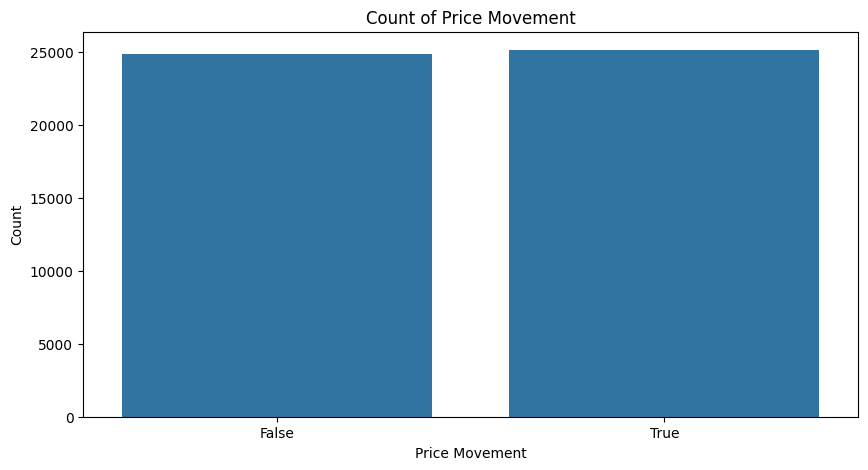

In [24]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Price_Movement', data=df)
plt.title('Count of Price Movement')
plt.xlabel('Price Movement')
plt.ylabel('Count')
plt.show()

The below code is needed to create copies of grouping of dates by quarter and year, since the number of years too huge. This would make it difficult to indicate to display for each date in a graph like format

In [25]:
# Group by quarter and calculate the mean of prices
df_quarter = df.set_index('Date').resample('Q').mean().reset_index()
df_year = df.set_index('Date').resample('Y').mean().reset_index()
df_month = df.set_index('Date').resample('M').mean().reset_index()

## Trend Analysis

#### Direct Crypto Price

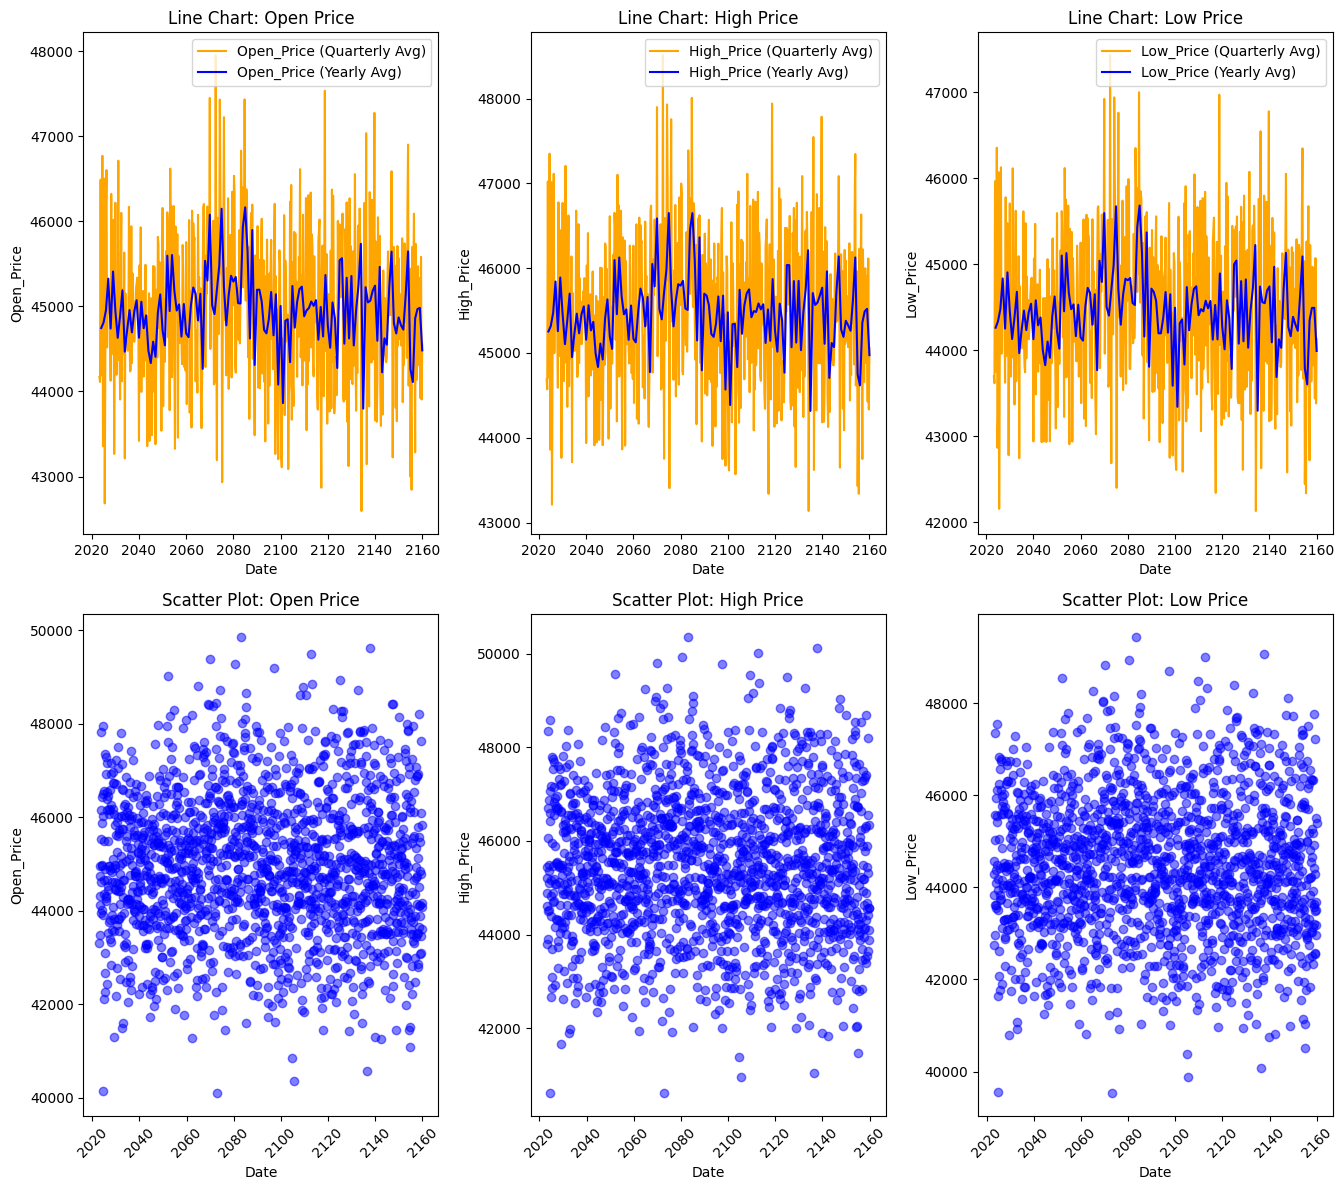

In [26]:
# Define the parameters and their descriptive titles
params = ['Open_Price', 'High_Price', 'Low_Price']
titles  = ['Open Price', 'High Price', 'Low Price']

plt.figure(figsize=(18, 12))

# Plot line charts using quarterly and yearly resampled data (top row)
for i, param in enumerate(params):
    plt.subplot(2, 4, i+1)
    plt.plot(df_quarter['Date'], df_quarter[param], label=f'{param} (Quarterly Avg)', color='orange')
    plt.plot(df_year['Date'], df_year[param], label=f'{param} (Yearly Avg)', color='blue')
    plt.title(f'Line Chart: {titles[i]}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.legend()

# Plot scatter plots using monthly resampled data (bottom row)
for i, param in enumerate(params):
    plt.subplot(2, 4, i+5)
    plt.scatter(df_month['Date'], df_month[param], color='blue', alpha=0.5)
    plt.title(f'Scatter Plot: {titles[i]}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

#### Parametrics Indicators

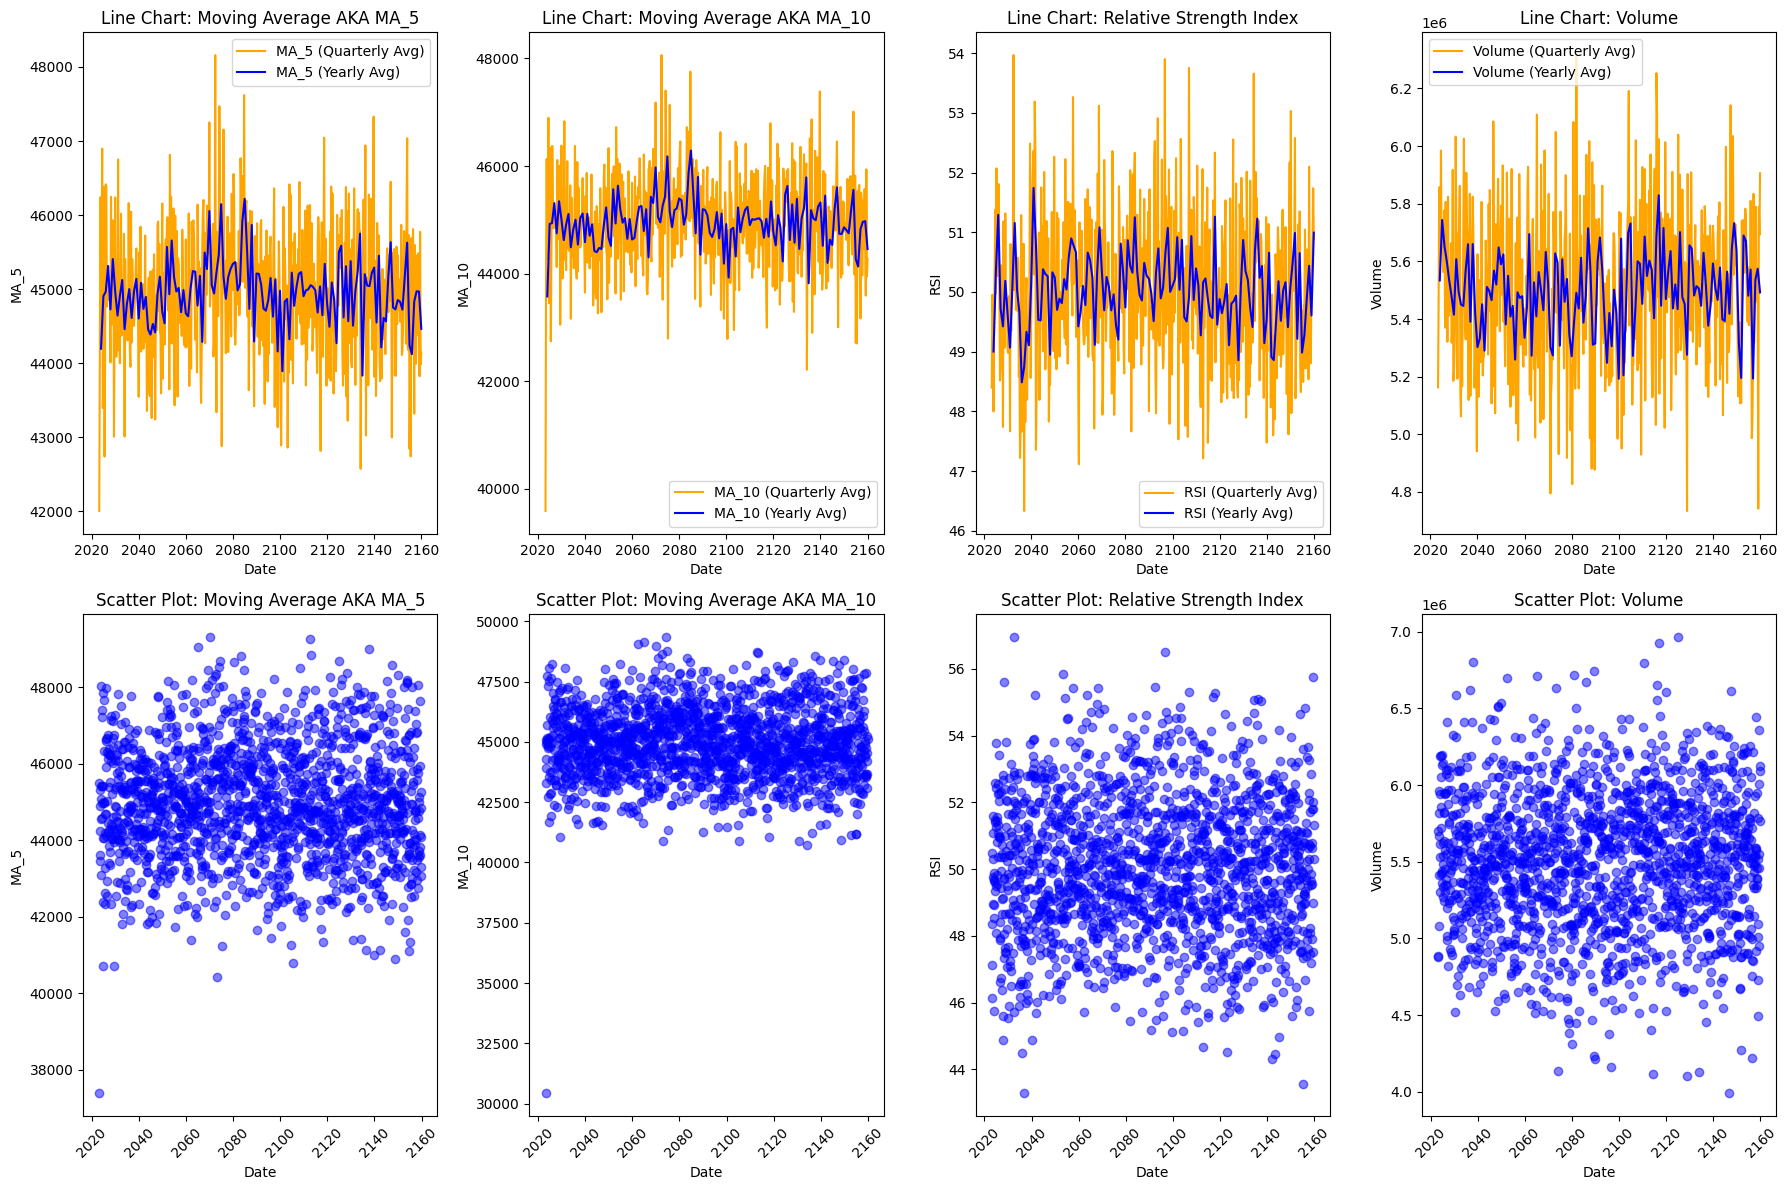

In [27]:
# Updated parameters and their descriptive titles to include Volume
params = ['MA_5', 'MA_10', 'RSI', 'Volume']
titles = ['Moving Average AKA MA_5', 'Moving Average AKA MA_10', 'Relative Strength Index', 'Volume']

plt.figure(figsize=(18, 12))

# Plot line charts using quarterly and yearly resampled data (top row)
for i, param in enumerate(params):
    plt.subplot(2, 4, i+1)
    plt.plot(df_quarter['Date'], df_quarter[param], label=f'{param} (Quarterly Avg)', color='orange')
    plt.plot(df_year['Date'], df_year[param], label=f'{param} (Yearly Avg)', color='blue')
    plt.title(f'Line Chart: {titles[i]}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.legend()

# Plot scatter plots using monthly resampled data (bottom row)
for i, param in enumerate(params):
    plt.subplot(2, 4, i+5)
    plt.scatter(df_month['Date'], df_month[param], color='blue', alpha=0.5)
    plt.title(f'Scatter Plot: {titles[i]}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()


#### External and Behavioral

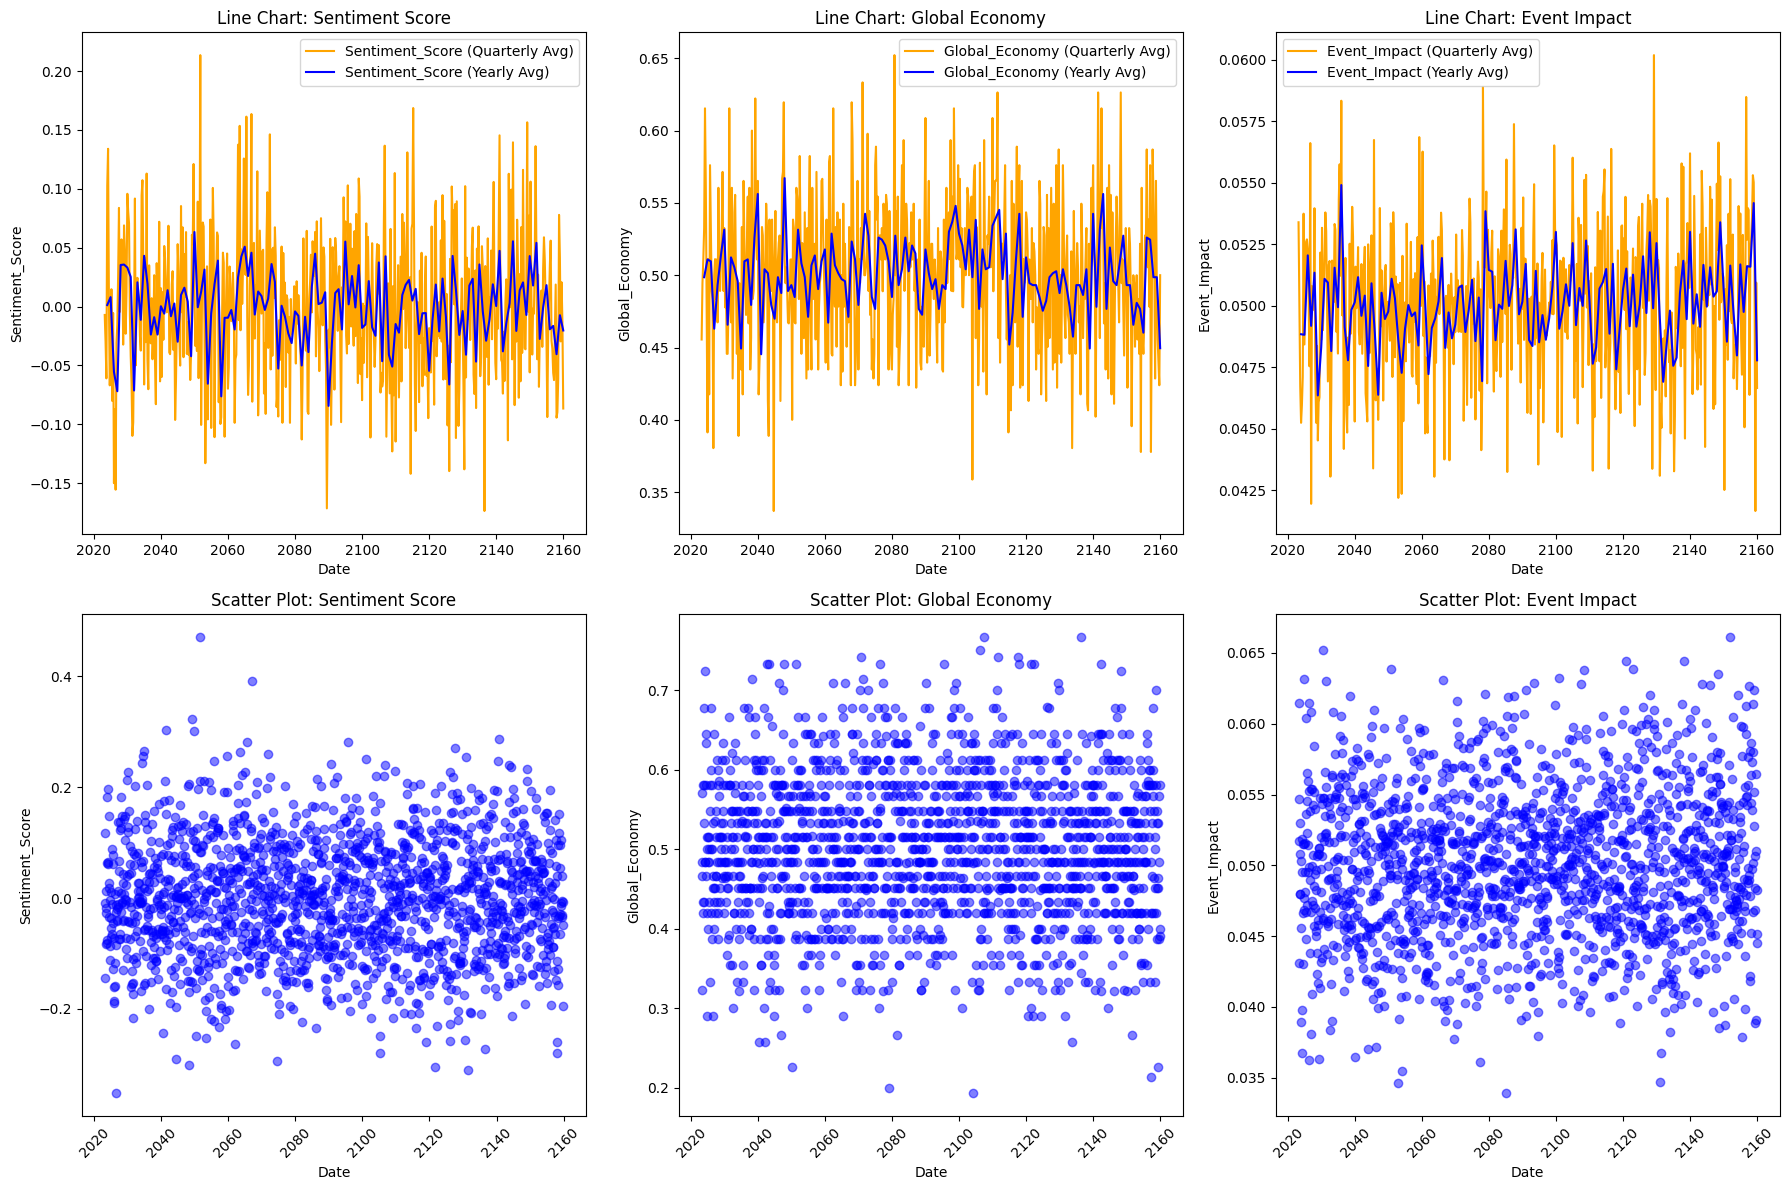

In [28]:
# Define the parameters and their descriptive titles
params = ['Sentiment_Score', 'Global_Economy', 'Event_Impact']
titles = ['Sentiment Score', 'Global Economy', 'Event Impact']

plt.figure(figsize=(18, 12))

# Plot line charts using quarterly and yearly resampled data (top row)
for i, param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.plot(df_quarter['Date'], df_quarter[param], label=f'{param} (Quarterly Avg)', color='orange')
    plt.plot(df_year['Date'], df_year[param], label=f'{param} (Yearly Avg)', color='blue')
    plt.title(f'Line Chart: {titles[i]}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.legend()

# Plot scatter plots using monthly resampled data (bottom row)
for i, param in enumerate(params):
    plt.subplot(2, 3, i+4)
    plt.scatter(df_month['Date'], df_month[param], color='blue', alpha=0.5)
    plt.title(f'Scatter Plot: {titles[i]}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

The trends reveal the following information: 

1. No sustained upward/downward drift: All series hover around a constant mean.

2. No clear seasonality: Quarterly swings look random rather than cyclical.

3. Stable variance: The amplitude of the quarterly fluctuations doesn’t grow or shrink over time.


This only means that further data analysis on the overall trend needs to be done, to gain further insights on how their movement actually is. 

## Tests on data trends

### ADF (Augmented Dickey–Fuller) test

In [29]:
from statsmodels.tsa.stattools import adfuller

def adf_test_all(data):
    results = []
    for col in data.columns:
        if col == 'Date':
            continue
        series = data[col].dropna()
        try:
            result = adfuller(series)
            results.append({
                'Feature': col,
                'ADF Statistic': result[0],
                'p-value': result[1],
                '1% Critical': result[4]['1%'],
                '5% Critical': result[4]['5%'],
                '10% Critical': result[4]['10%']
            })
        except Exception as e:
            results.append({
                'Feature': col,
                'ADF Statistic': None,
                'p-value': None,
                '1% Critical': None,
                '5% Critical': None,
                '10% Critical': None,
                'Error': str(e)
            })
    return pd.DataFrame(results)

adf_results = adf_test_all(df)
print(adf_results.to_string(index=False))

        Feature  ADF Statistic  p-value  1% Critical  5% Critical  10% Critical
     Open_Price    -223.548056      0.0    -3.430481    -2.861598     -2.566801
     High_Price    -223.491795      0.0    -3.430481    -2.861598     -2.566801
      Low_Price    -223.572564      0.0    -3.430481    -2.861598     -2.566801
         Volume    -224.579563      0.0    -3.430481    -2.861598     -2.566801
           MA_5     -28.119202      0.0    -3.430481    -2.861598     -2.566801
          MA_10     -28.092087      0.0    -3.430481    -2.861598     -2.566801
            RSI    -222.480967      0.0    -3.430481    -2.861598     -2.566801
     Volatility    -225.591740      0.0    -3.430481    -2.861598     -2.566801
Sentiment_Score    -224.138753      0.0    -3.430481    -2.861598     -2.566801
 Global_Economy    -222.278091      0.0    -3.430481    -2.861598     -2.566801
   Event_Impact    -224.441003      0.0    -3.430481    -2.861598     -2.566801
 Price_Movement    -223.654314      0.0 

The ADF test outputs indicate that for every feature:
- The ADF Statistic is extremely low (much lower than the 1%, 5%, and 10% critical values).
- The p-values are effectively 0.

This implies that we can strongly reject the null hypothesis of a unit root for all features. In other words, all the time series in the dataset are stationary.

Stationarity is important when modeling time series data because it means that the statistical properties (mean, variance, etc.) remain constant over time. This improves the performance and reliability of subsequent modeling techniques, such as forecasting methods (e.g., ARIMA) or deep learning models (e.g., LSTM). The stationarity observed here assures us that no additional differencing or detrending is required for most modeling applications.

### ACF and PACF Tests

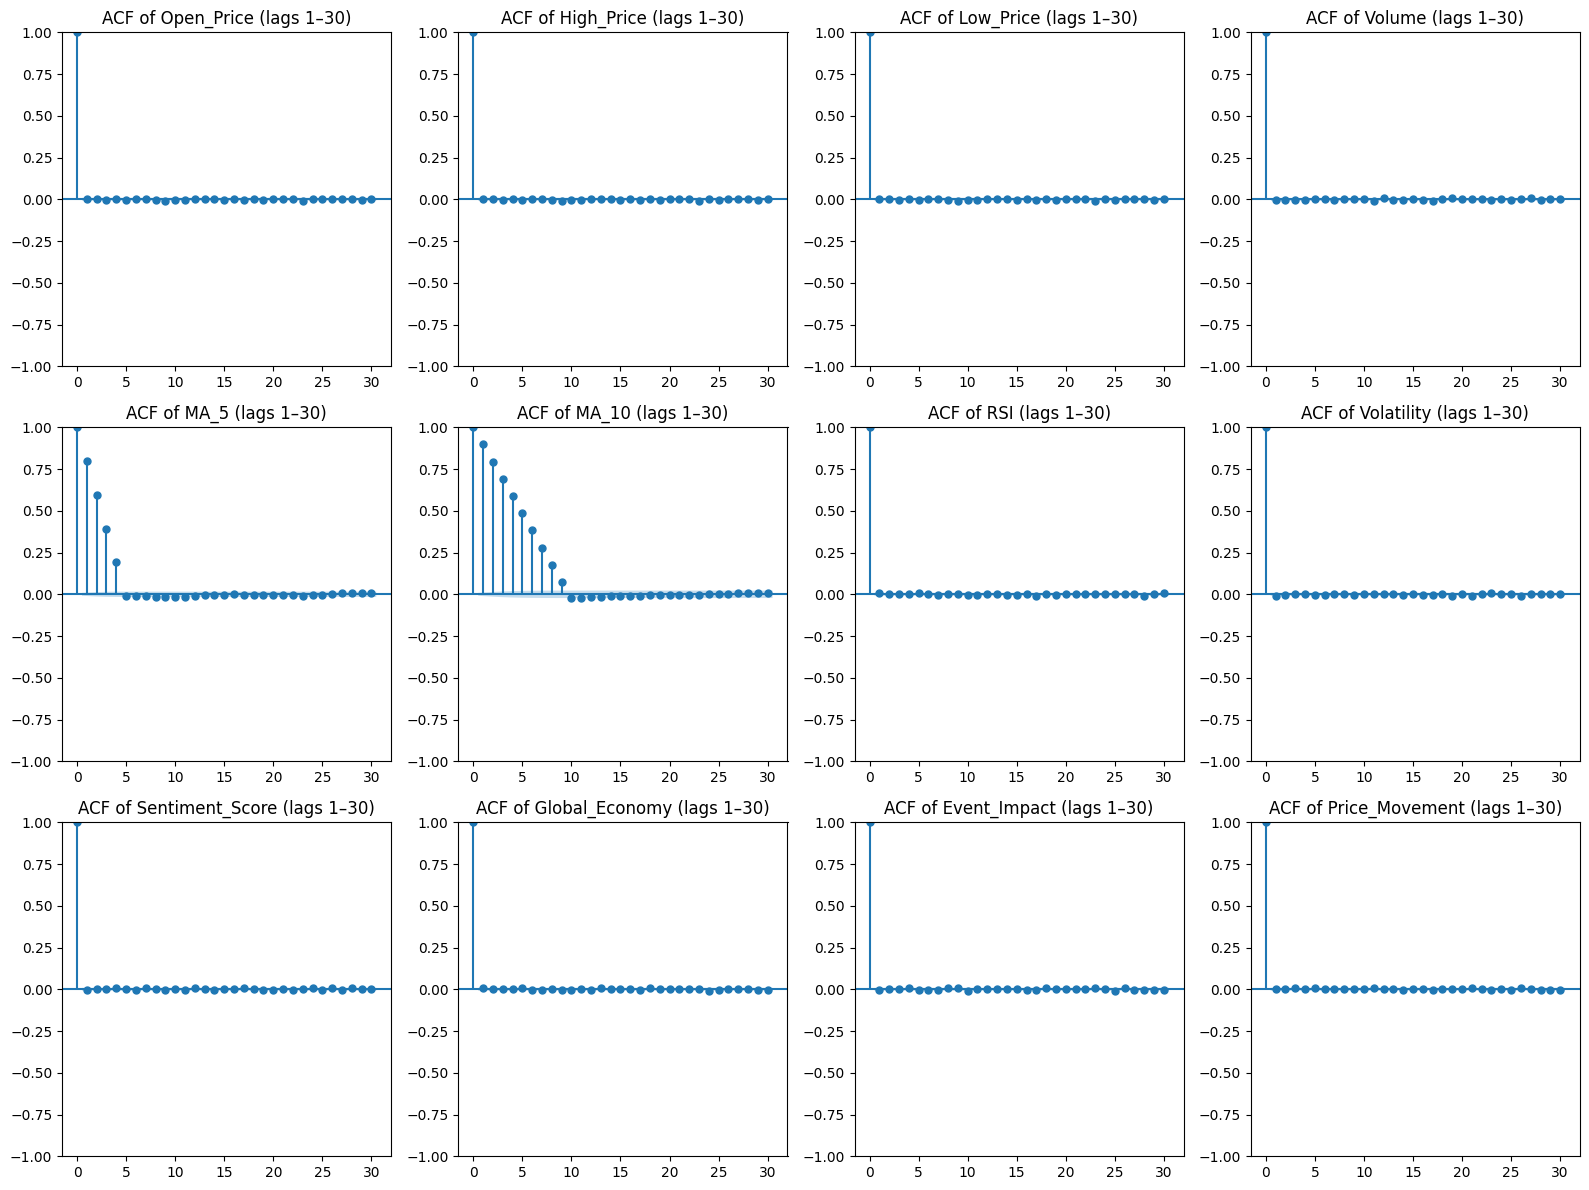

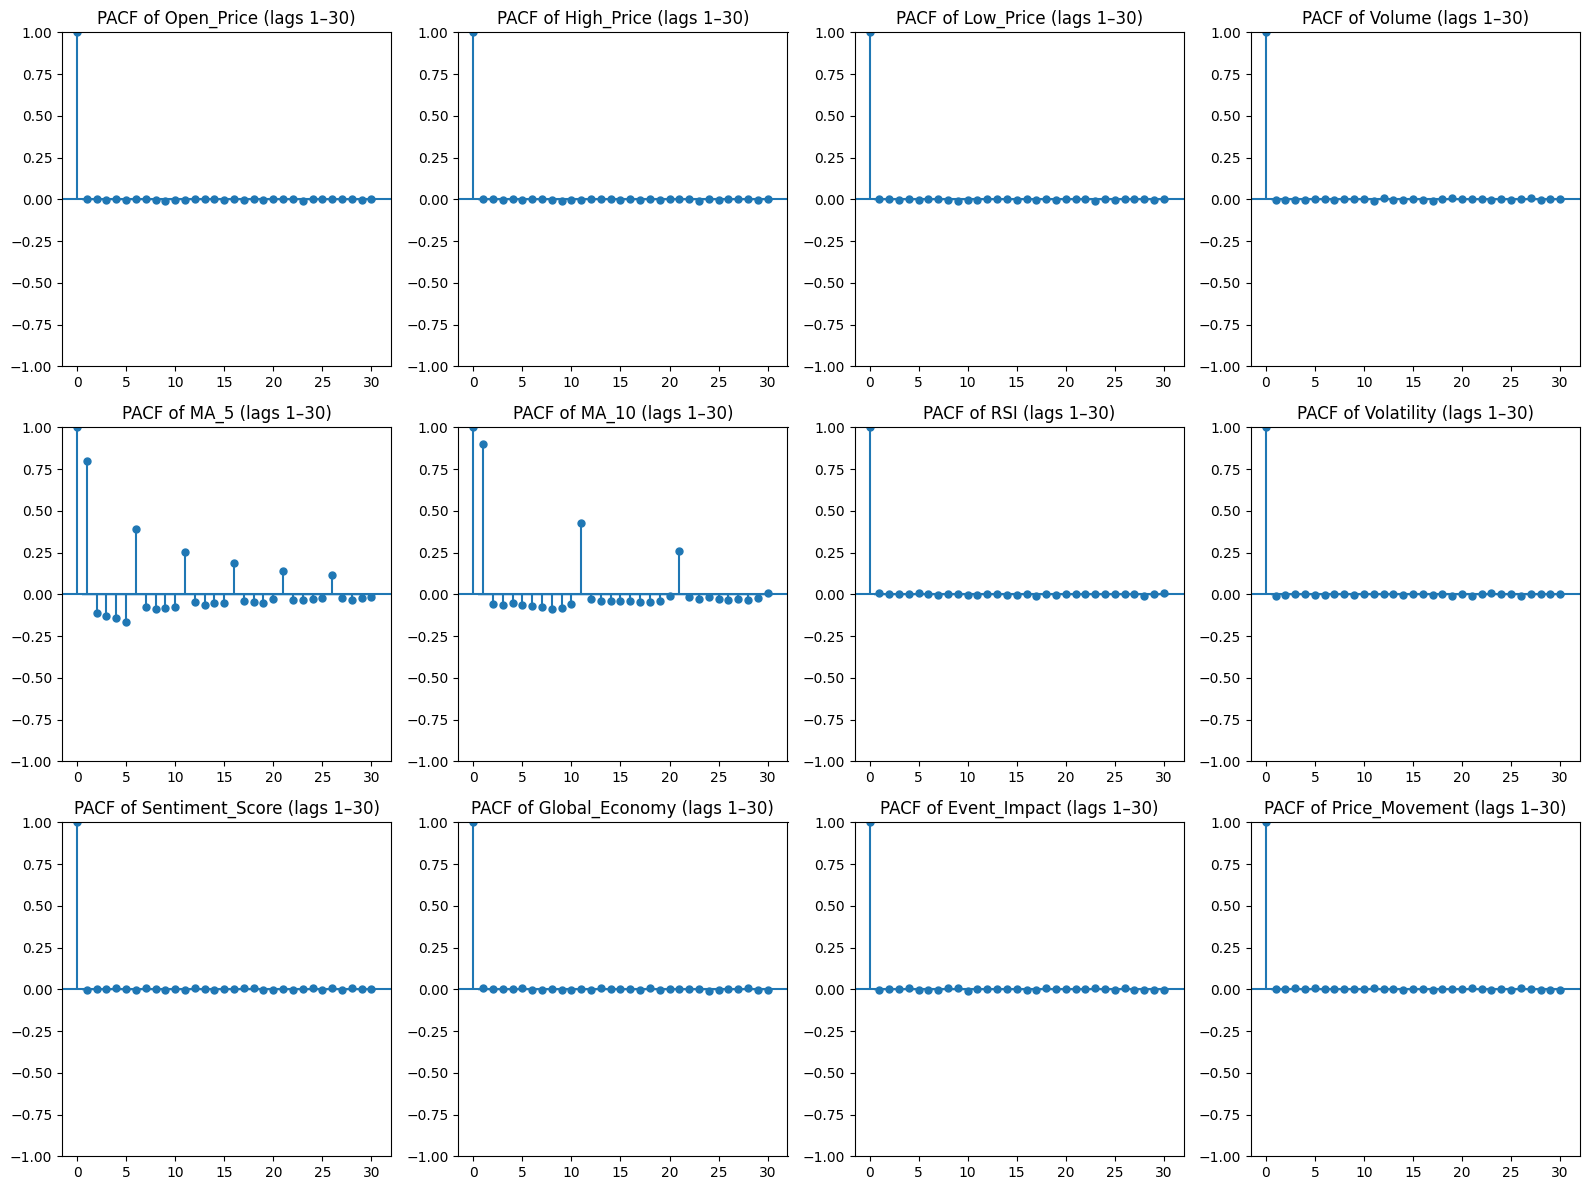

In [30]:
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


features = df.columns.tolist()
features.remove('Date')

# Determine grid size (4 plots per row)
n_cols = 4
n_rows = math.ceil(len(features) / n_cols)

# Plot ACF for each feature
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    plot_acf(df[feature], lags=30, ax=axes[i])
    axes[i].set_title(f'ACF of {feature} (lags 1–30)')

# Turn off any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Plot PACF for each feature
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    plot_pacf(df[feature], lags=30, ax=axes[i])
    axes[i].set_title(f'PACF of {feature} (lags 1–30)')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots helps understand the dependence structure in this time series data. Here’s the intuition:

- The ACF plot shows how past values are correlated with the current value over various lags, while the PACF shows the direct correlation at each lag after removing effects from all shorter lags.
- When both plots quickly drop to 0 (stabilize at zero), it suggests that there isn’t significant autocorrelation beyond a certain lag. This indicates that the series does not strongly depend on many past values.
- For LSTM or other RNN models, knowing that autocorrelation dies out quickly means that very long input sequences might not be necessary, and I can focus on a key window of past data.
- **A lag of 30 is chosen because it is large enough to capture any potential monthly seasonal patterns or short-term dependencies, yet small enough to avoid including noise or redundant information.**

This insight assists in configuring the sequence length (window size) for LSTM inputs and helps simplify the model by avoiding unnecessarily long historical windows.

Key takeaway from ACF/PACF:

All the time series are stationary and show virtually zero autocorrelation at lags > 0—except for the two moving‑average features.

MA_5 has significant autocorrelation out to lag 4 (ACF) and partial spikes at lags 1–2 (PACF).

MA_10 shows autocorrelation through lag 8 and PACF spikes at lag 1 (and weaker at 10 and 20).

#### Creating Dataframe with lags

In [31]:
# Create lagged features for MA_5 (up to lag 4) and MA_10 (up to lag 8)
for lag in range(1, 5):
    df[f'MA_5_lag_{lag}'] = df['MA_5'].shift(lag)

for lag in range(1, 9):
    df[f'MA_10_lag_{lag}'] = df['MA_10'].shift(lag)

# Drop rows with NaN values (from the lagging operation)
df_with_lags = df.dropna()

print(f"Original shape: {df.shape}")
print(f"Shape after adding lags and dropping NaN rows: {df_with_lags.shape}")
print(f"Number of rows dropped: {df.shape[0] - df_with_lags.shape[0]}")

# Show a sample of the new lagged columns
lag_cols = [col for col in df_with_lags.columns if 'lag' in col]
print("\nSample of the lagged columns:")
print(df_with_lags[lag_cols].head())

Original shape: (50000, 25)
Shape after adding lags and dropping NaN rows: (49992, 25)
Number of rows dropped: 8

Sample of the lagged columns:
      MA_5_lag_1    MA_5_lag_2    MA_5_lag_3    MA_5_lag_4   MA_10_lag_1  \
8   41007.347755  40115.030855  45548.265371  46910.060781      0.000000   
9   40949.468660  41007.347755  40115.030855  45548.265371      0.000000   
10  44244.894607  40949.468660  41007.347755  40115.030855  45577.477694   
11  43509.492070  44244.894607  40949.468660  41007.347755  44528.878721   
12  49045.482581  43509.492070  44244.894607  40949.468660  44580.256718   

     MA_10_lag_2   MA_10_lag_3  MA_10_lag_4  MA_10_lag_5  MA_10_lag_6  \
8       0.000000      0.000000          0.0          0.0          0.0   
9       0.000000      0.000000          0.0          0.0          0.0   
10      0.000000      0.000000          0.0          0.0          0.0   
11  45577.477694      0.000000          0.0          0.0          0.0   
12  44528.878721  45577.477694    

In [32]:
df_with_lags.head()

,Date,Open_Price,High_Price,Low_Price,Volume,MA_5,MA_10,RSI,Volatility,Sentiment_Score,...,MA_5_lag_3,MA_5_lag_4,MA_10_lag_1,MA_10_lag_2,MA_10_lag_3,MA_10_lag_4,MA_10_lag_5,MA_10_lag_6,MA_10_lag_7,MA_10_lag_8
8,2023-01-09,48033.450352,48247.693265,47404.905785,7657491,40949.468660,0.000000,50.362972,0.039068,0.368426,...,45548.265371,46910.060781,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
9,2023-01-10,51242.177334,51585.786577,50578.183972,8341889,44244.894607,45577.477694,40.800996,0.020739,0.183730,...,40115.030855,45548.265371,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
10,2023-01-11,30617.534829,31108.106707,30455.397526,2212450,43509.492070,44528.878721,51.482607,0.035209,0.627652,...,41007.347755,40115.030855,45577.477694,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11,2023-01-12,59097.295565,59900.004347,58784.035582,4462601,49045.482581,44580.256718,33.144940,0.016401,0.662849,...,40949.468660,41007.347755,44528.878721,45577.477694,0.000000,0.0,0.0,0.0,0.0,0.0
12,2023-01-13,54973.279224,55396.713428,54378.735255,9775141,48852.372428,44929.860092,43.650581,0.014083,-0.864761,...,44244.894607,40949.468660,44580.256718,44528.878721,45577.477694,0.0,0.0,0.0,0.0,0.0


In [33]:
#does df have null
print(df.isnull().sum())
df = df.dropna()

Date               0
Open_Price         0
High_Price         0
Low_Price          0
Volume             0
MA_5               0
MA_10              0
RSI                0
Volatility         0
Sentiment_Score    0
Global_Economy     0
Event_Impact       0
Price_Movement     0
MA_5_lag_1         1
MA_5_lag_2         2
MA_5_lag_3         3
MA_5_lag_4         4
MA_10_lag_1        1
MA_10_lag_2        2
MA_10_lag_3        3
MA_10_lag_4        4
MA_10_lag_5        5
MA_10_lag_6        6
MA_10_lag_7        7
MA_10_lag_8        8
dtype: int64


In [34]:
# Compute the change in Sentiment_Score over a 3‑day window
df['Sentiment_deltas'] = df['Sentiment_Score'] - df['Sentiment_Score'].shift(3)
print(df[['Date', 'Sentiment_Score', 'Sentiment_deltas']].head(7))

         Date  Sentiment_Score  Sentiment_deltas
8  2023-01-09         0.368426               NaN
9  2023-01-10         0.183730               NaN
10 2023-01-11         0.627652               NaN
11 2023-01-12         0.662849          0.294423
12 2023-01-13        -0.864761         -1.048490
13 2023-01-14        -0.455792         -1.083444
14 2023-01-15        -0.536278         -1.199126


In [35]:
df = df.dropna()

print(df.shape)
print(df.head())

(49989, 26)
         Date    Open_Price    High_Price     Low_Price   Volume  \
11 2023-01-12  59097.295565  59900.004347  58784.035582  4462601   
12 2023-01-13  54973.279224  55396.713428  54378.735255  9775141   
13 2023-01-14  36370.173320  36938.992350  36371.219308  5726515   
14 2023-01-15  35454.749016  35211.603012  34107.853810  4617507   
15 2023-01-16  35502.135296  36428.171405  35625.323065  4181273   

            MA_5         MA_10        RSI  Volatility  Sentiment_Score  ...  \
11  49045.482581  44580.256718  33.144940    0.016401         0.662849  ...   
12  48852.372428  44929.860092  43.650581    0.014083        -0.864761  ...   
13  46570.552431  43760.010546  44.739048    0.031359        -0.455792  ...   
14  43367.089528  43805.992068  37.650721    0.022054        -0.536278  ...   
15  44297.612013  43903.552042  39.993981    0.015498        -0.320854  ...   

      MA_5_lag_4   MA_10_lag_1   MA_10_lag_2   MA_10_lag_3   MA_10_lag_4  \
11  41007.347755  44528.8787

### Condition Distributional Analysis

In [36]:
# Compute Cohen's d and define sorted_features for KDE plots
def cohen_d(x, y):
    return (x.mean() - y.mean()) / np.sqrt((x.std()**2 + y.std()**2) / 2)

# Choose features for KDE plots (exclude non-numeric or target columns)
features_for_kde = [col for col in df_with_lags.columns if col not in ['Date', 'Price_Movement']]

sorted_features = []
for feat in features_for_kde:
    data0 = df_with_lags[df_with_lags['Price_Movement'] == 0][feat].dropna()
    data1 = df_with_lags[df_with_lags['Price_Movement'] == 1][feat].dropna()
    if len(data0) > 0 and len(data1) > 0:
        d_value = cohen_d(data0, data1)
        sorted_features.append((feat, d_value))

# Sort features by the absolute value of Cohen's d (largest differences first)
sorted_features = sorted(sorted_features, key=lambda x: abs(x[1]), reverse=True)

# Plot the KDE plots in pairs based on the sorted order and print stats for all features
for feat, d_value in sorted_features:
    # Separate the two classes for this feature
    data0 = df_with_lags[df_with_lags['Price_Movement'] == 0][feat].dropna()
    data1 = df_with_lags[df_with_lags['Price_Movement'] == 1][feat].dropna()
    
    # Compute the summary statistics for this feature
    mean0, std0 = data0.mean(), data0.std()
    mean1, std1 = data1.mean(), data1.std()
    
    print(f"Feature: {feat}")
    print(f"  Price_Movement = 0: mean={mean0:.4f}, std={std0:.4f}")
    print(f"  Price_Movement = 1: mean={mean1:.4f}, std={std1:.4f}")
    print(f"  Cohen's d: {d_value:.4f}\n")


Feature: Low_Price
  Price_Movement = 0: mean=44287.2751, std=8685.8797
  Price_Movement = 1: mean=44641.5198, std=8628.2250
  Cohen's d: -0.0409

Feature: High_Price
  Price_Movement = 0: mean=45290.4640, std=8685.1650
  Price_Movement = 1: mean=45643.5760, std=8630.5687
  Cohen's d: -0.0408

Feature: MA_5
  Price_Movement = 0: mean=44909.2572, std=3876.8367
  Price_Movement = 1: mean=45021.7189, std=3863.8965
  Cohen's d: -0.0291

Feature: MA_10
  Price_Movement = 0: mean=44937.6176, std=2732.5708
  Price_Movement = 1: mean=44991.8152, std=2730.0049
  Cohen's d: -0.0198

Feature: Open_Price
  Price_Movement = 0: mean=45040.3150, std=8679.6576
  Price_Movement = 1: mean=44892.3123, std=8624.0607
  Cohen's d: 0.0171

Feature: MA_5_lag_1
  Price_Movement = 0: mean=44932.4455, std=3884.4170
  Price_Movement = 1: mean=44998.4715, std=3856.9159
  Cohen's d: -0.0171

Feature: MA_5_lag_2
  Price_Movement = 0: mean=44933.6315, std=3871.4783
  Price_Movement = 1: mean=44997.0824, std=3869.9216

As expected to see that there is significant difference between the Cohen's d score between the values, however no major correlation was found with this metric as well. We were ideally looking for a score of greater than 0.5. 

Most values of Chohen's d is close to 0, which indicates that each feature for Up vs. Down days are almost identical relative to their spread. Therefore none of these features, on their own, shift enough between classes to serve as a reliable “signal.”

In [37]:
from sklearn.feature_selection import mutual_info_classif

# Exclude Price_Change, Date, and the target Price_Movement
features_for_mi = [col for col in df.columns if col not in ['Date', 'Price_Change', 'Price_Movement']]
X_mi = df[features_for_mi]
y_mi = df['Price_Movement']

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)

# Create a DataFrame mapping feature names to their MI scores
mi_df = pd.DataFrame({
    'Feature': features_for_mi,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

print(mi_df)

             Feature  MI Score
2          Low_Price  0.005010
16       MA_10_lag_2  0.003769
0         Open_Price  0.003736
5              MA_10  0.002563
6                RSI  0.002562
1         High_Price  0.002265
12        MA_5_lag_2  0.001701
4               MA_5  0.001541
21       MA_10_lag_7  0.001107
14        MA_5_lag_4  0.000922
23  Sentiment_deltas  0.000851
20       MA_10_lag_6  0.000584
7         Volatility  0.000381
9     Global_Economy  0.000186
13        MA_5_lag_3  0.000000
11        MA_5_lag_1  0.000000
8    Sentiment_Score  0.000000
3             Volume  0.000000
17       MA_10_lag_3  0.000000
18       MA_10_lag_4  0.000000
19       MA_10_lag_5  0.000000
10      Event_Impact  0.000000
22       MA_10_lag_8  0.000000
15       MA_10_lag_1  0.000000


In [38]:
drop_features = [
    'MA_5_lag_3',
    'MA_5_lag_1',
    'Sentiment_Score',
    'Volume',
    'MA_10_lag_3',
    'MA_10_lag_4',
    'MA_10_lag_5',
    'Event_Impact',
    'MA_10_lag_8',
    'MA_10_lag_1',
    'MA_5_lag_4',
    'Sentiment_deltas',
    'MA_10_lag_6',
    'Volatility',
    'Global_Economy'
]

existing_drop_features = [col for col in drop_features if col in df.columns]

df = df.drop(columns=existing_drop_features)
print(df.shape)
df.head()

existing_drop_features = [col for col in drop_features if col in df.columns]

df = df.drop(columns=existing_drop_features)
print(df.shape)
df.head()

(49989, 11)
(49989, 11)


,Date,Open_Price,High_Price,Low_Price,MA_5,MA_10,RSI,Price_Movement,MA_5_lag_2,MA_10_lag_2,MA_10_lag_7
11,2023-01-12,59097.295565,59900.004347,58784.035582,49045.482581,44580.256718,33.144940,False,44244.894607,45577.477694,0.0
12,2023-01-13,54973.279224,55396.713428,54378.735255,48852.372428,44929.860092,43.650581,True,43509.492070,44528.878721,0.0
13,2023-01-14,36370.173320,36938.992350,36371.219308,46570.552431,43760.010546,44.739048,True,49045.482581,44580.256718,0.0
14,2023-01-15,35454.749016,35211.603012,34107.853810,43367.089528,43805.992068,37.650721,False,48852.372428,44929.860092,0.0
15,2023-01-16,35502.135296,36428.171405,35625.323065,44297.612013,43903.552042,39.993981,True,46570.552431,43760.010546,0.0


In [39]:
#Save this new dataframe to a csv file
df.to_csv('Dataset/crypto_price_movement_dataset_cleaned.csv', index=False)